In [1]:
import healpy as h
import numpy as np
from modules import ana_moment_fit
from modules import ml_moment_fit as mlfit
%pylab notebook
import os


figpath="./figures/"
!mkdir $figpath

Populating the interactive namespace from numpy and matplotlib
mkdir: ./figures/: File exists


In [15]:
nside_moments=128 ; nside_freq=8 # Make sure the nside_freq is greater than or equalt to 2.
freq=[100,143,217,353,545,857]
K2MJypsr=[238.815,380.0,483.82,296.877,1.,1.]
K2MJypsr_cmb=[238.815,380.0,483.82,296.877,57.1943,1.43907]

do_spectra_plots=False
lmax=3*nside_moments ; ell=arange(lmax+1)

# Setting number of pixels
num_moments_pix=h.nside2npix(nside_moments) 
num_freq_pix=h.nside2npix(nside_freq)

nu=np.array(freq).astype("float")

<IPython.core.display.Javascript object>


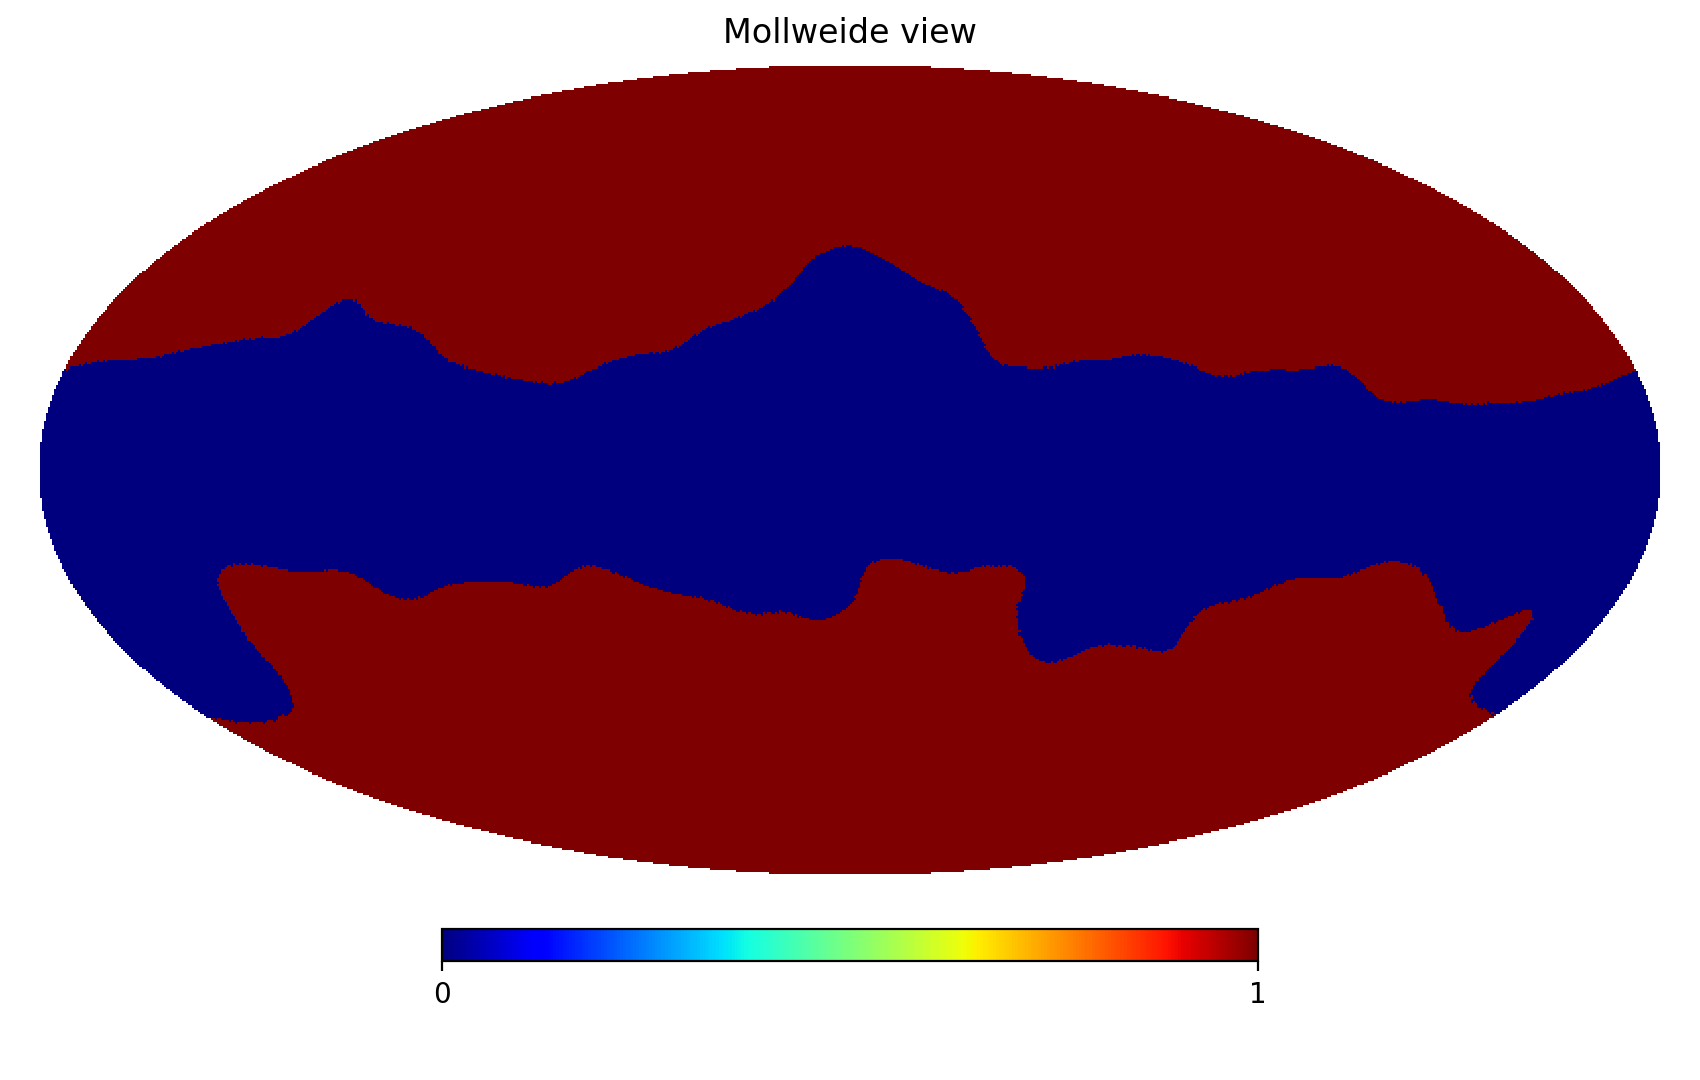

In [16]:
mask=h.read_map("../data/Planck/mask_gal60_nside512.fits",verbose=False)
mask=h.read_map("../data/Planck/HFI_Mask_GalPlane-apo0_2048_R2.00.fits",2,verbose=False)
mask=h.ud_grade(mask,nside_moments)
mask[mask<0.8]=0 ; mask[mask>=0.8]=1.
h.mollview(mask)

In [38]:
band_mask=np.ones(num_freq_pix,float)
phi,theta=h.pix2ang(nside_freq,arange(num_freq_pix),lonlat=True)
band_mask[abs(theta)<15.]=0

<IPython.core.display.Javascript object>


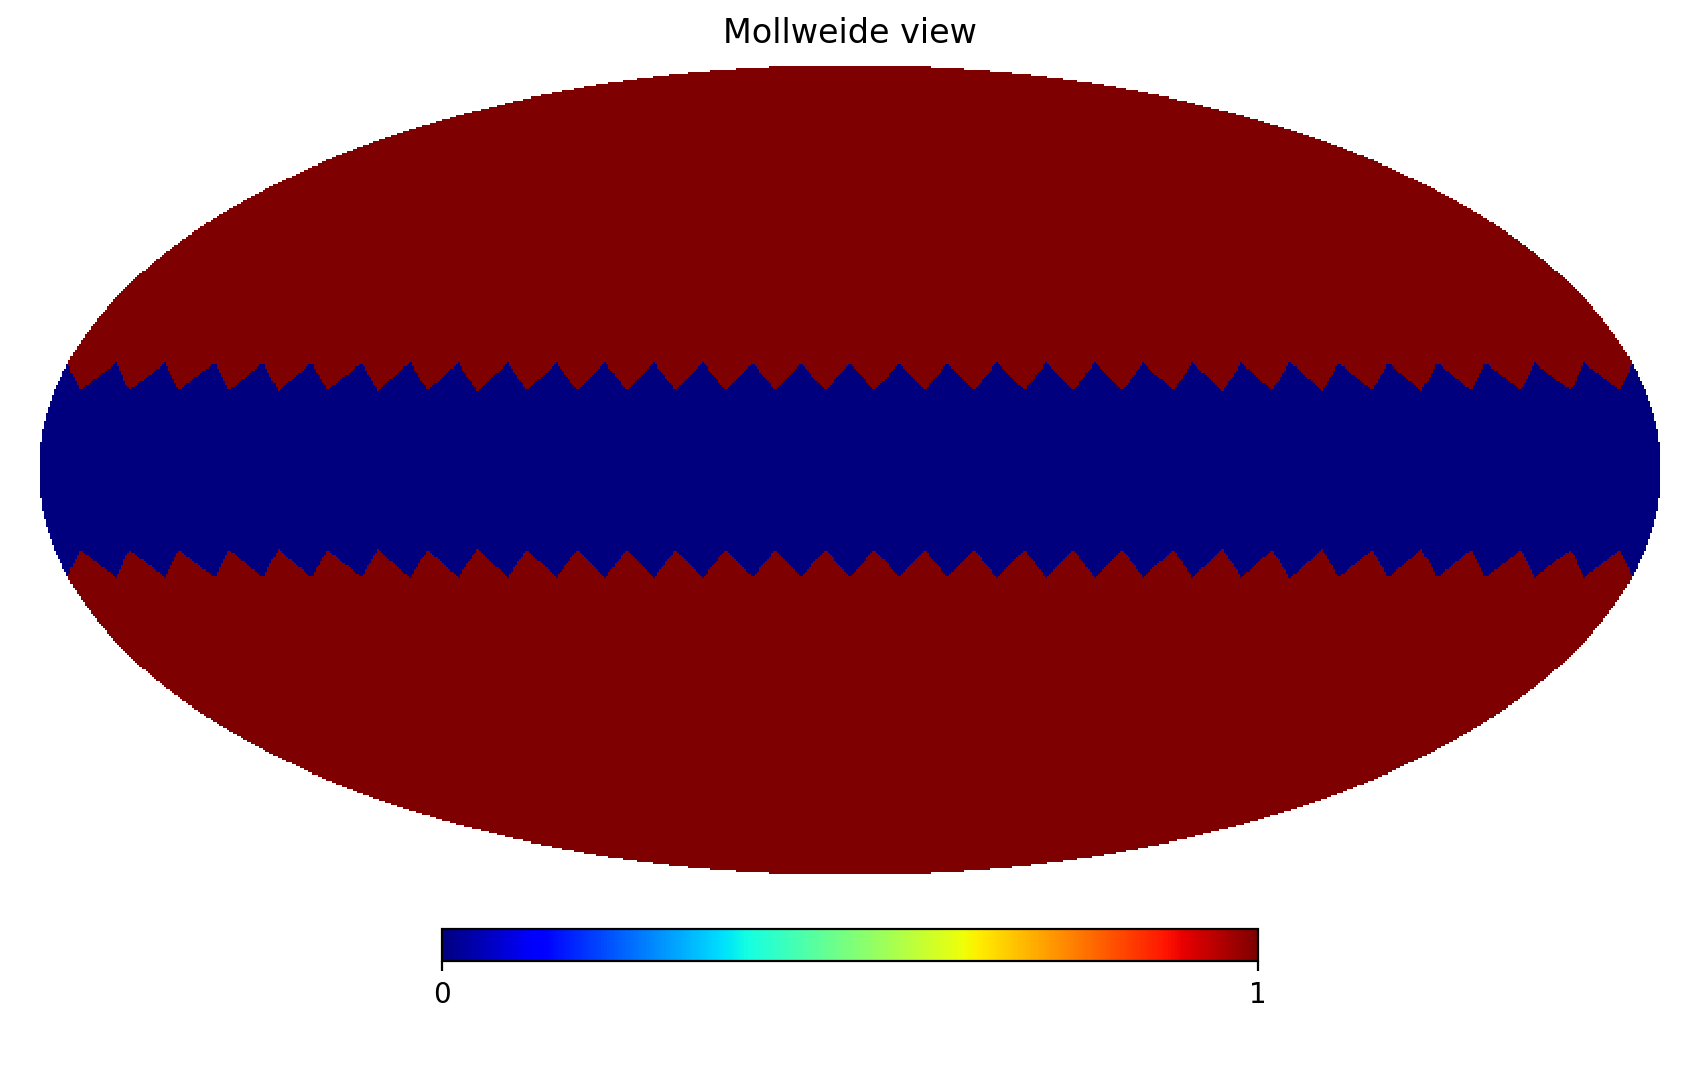

In [39]:
h.mollview(band_mask)

In [17]:
cmb=h.read_map("../data/Planck/COM_CMB_IQU-smica_1024_R2.02_full.fits",0,verbose=False)
cmb=h.ud_grade(cmb,nside_moments)

In [18]:
datapath="../data/Planck/"
fname_prefix="HFI_SkyMap_"
fname_suffix="_256_R2.02_nominal.fits"

npix=h.nside2npix(nside_moments)
freq=[100,143,217,353,545,857]

hfi=np.zeros((np.size(freq),num_moments_pix),np.float64)
cmb_freq=np.zeros((np.size(freq),num_moments_pix),np.float64)
hfi_err=np.zeros((np.size(freq),num_moments_pix),np.float64)
local_monopole=np.zeros((np.size(freq),num_freq_pix),np.float64)
local_monopole_err=np.zeros((np.size(freq),num_freq_pix),np.float64)

for i in range(np.size(freq)):
    filename=datapath + fname_prefix + str(freq[i]) + fname_suffix
    print filename
    data=h.read_map(filename,verbose=False,field=[0,1])
    if h.get_nside(data[0])!=nside_moments:
        cmb_freq[i,:]=cmb*K2MJypsr_cmb[i]
        hfi[i,:]=h.ud_grade(data[0],nside_moments)*K2MJypsr[i] - cmb_freq[i,:]
        local_monopole[i,:]=h.ud_grade(data[0],nside_freq)*K2MJypsr[i] - h.ud_grade(cmb_freq[i,:],nside_freq)
        hfi_err[i,:]=np.sqrt(h.ud_grade(data[1],nside_moments,power=2))*K2MJypsr[i]
        local_monopole_err[i,:]=np.sqrt(h.ud_grade(data[1],nside_freq,power=2))*K2MJypsr[i] 

../data/Planck/HFI_SkyMap_100_256_R2.02_nominal.fits
../data/Planck/HFI_SkyMap_143_256_R2.02_nominal.fits
../data/Planck/HFI_SkyMap_217_256_R2.02_nominal.fits
../data/Planck/HFI_SkyMap_353_256_R2.02_nominal.fits
../data/Planck/HFI_SkyMap_545_256_R2.02_nominal.fits
../data/Planck/HFI_SkyMap_857_256_R2.02_nominal.fits


In [20]:
random.seed(0)
noise=zeros((np.size(freq),num_moments_pix),float)
for i in range(size(freq)):
    noise[i,:]=randn(num_moments_pix)*hfi_err[i,:]

In [21]:
mf=ana_moment_fit.moment_fit(4)

# Fitting the local monopole with a MBB function

In [22]:
T_fit=np.zeros(num_freq_pix,np.float64)
slope_fit=np.zeros(num_freq_pix,np.float64)
A_fit=np.zeros(num_freq_pix,np.float64)
nu=np.array(freq).astype("float")
for i in range(num_freq_pix):
    par=mf.fit_monopole_sed(nu,local_monopole[:,i],0,lb=[1e-10,0.,-3.],ub=[1.,100.,3.],guess=[1e-3,15.,0.],bounds_true=True,err=local_monopole_err[:,i],maxfev=500000)
    A_fit[i]=par[0]
    T_fit[i]=par[1]
    slope_fit[i]=par[2]

<IPython.core.display.Javascript object>


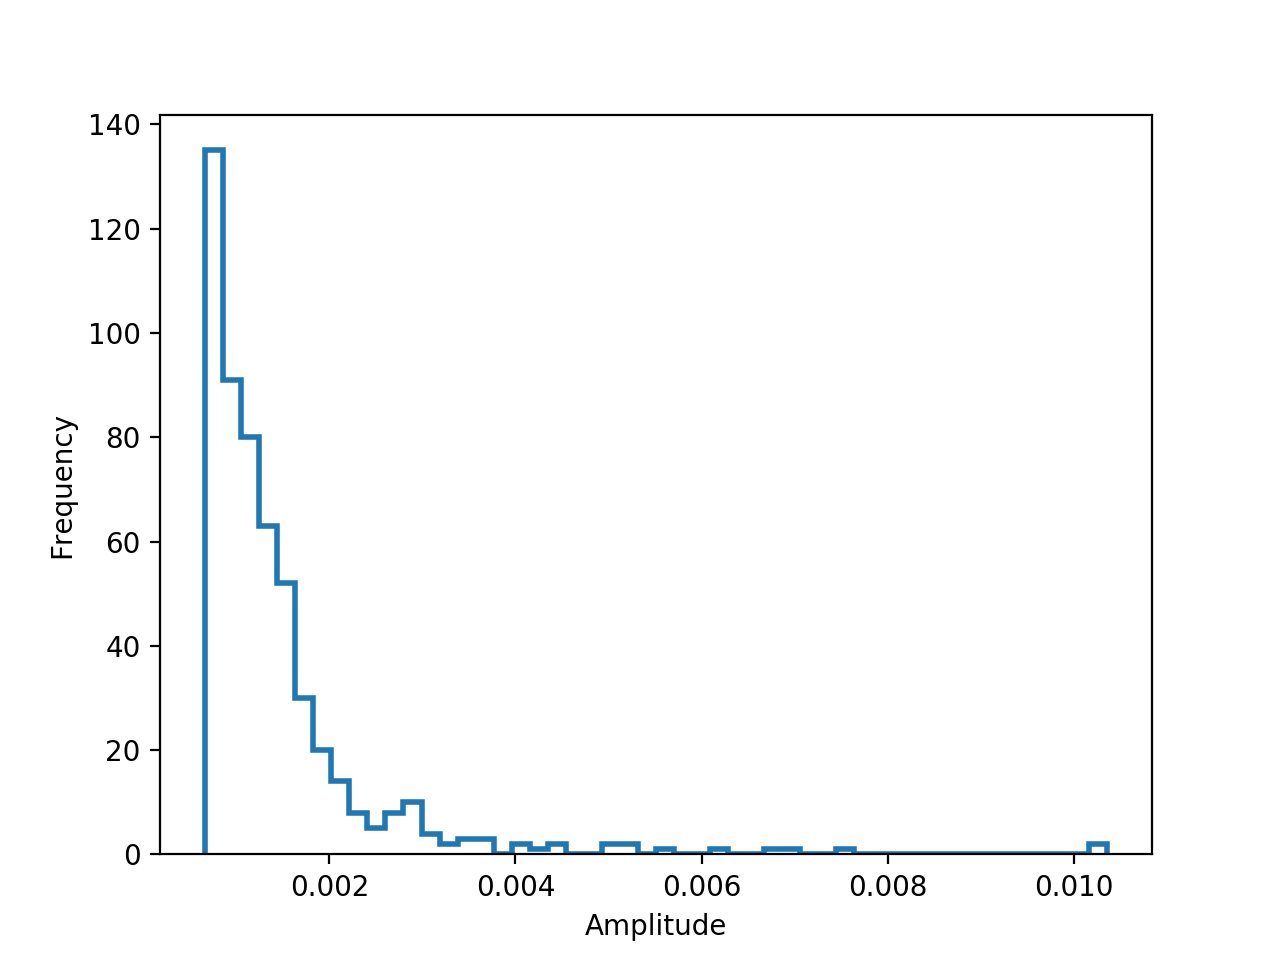

<IPython.core.display.Javascript object>


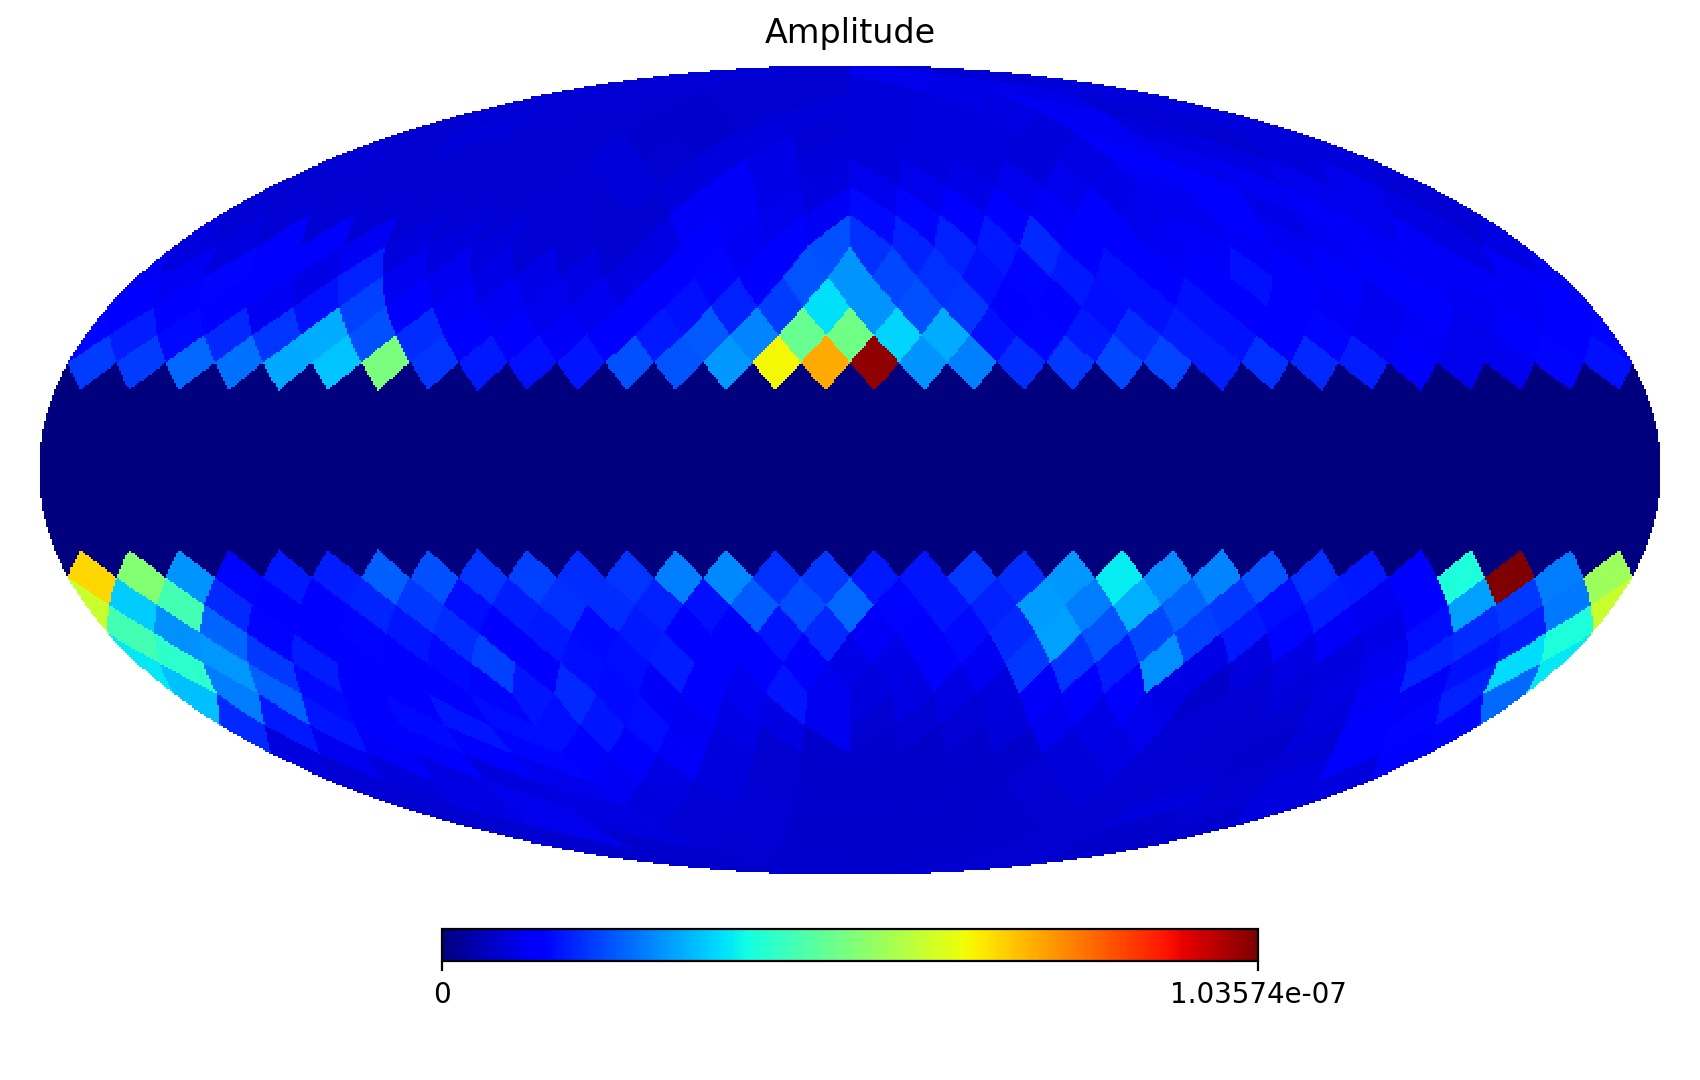

16.783237198


<IPython.core.display.Javascript object>


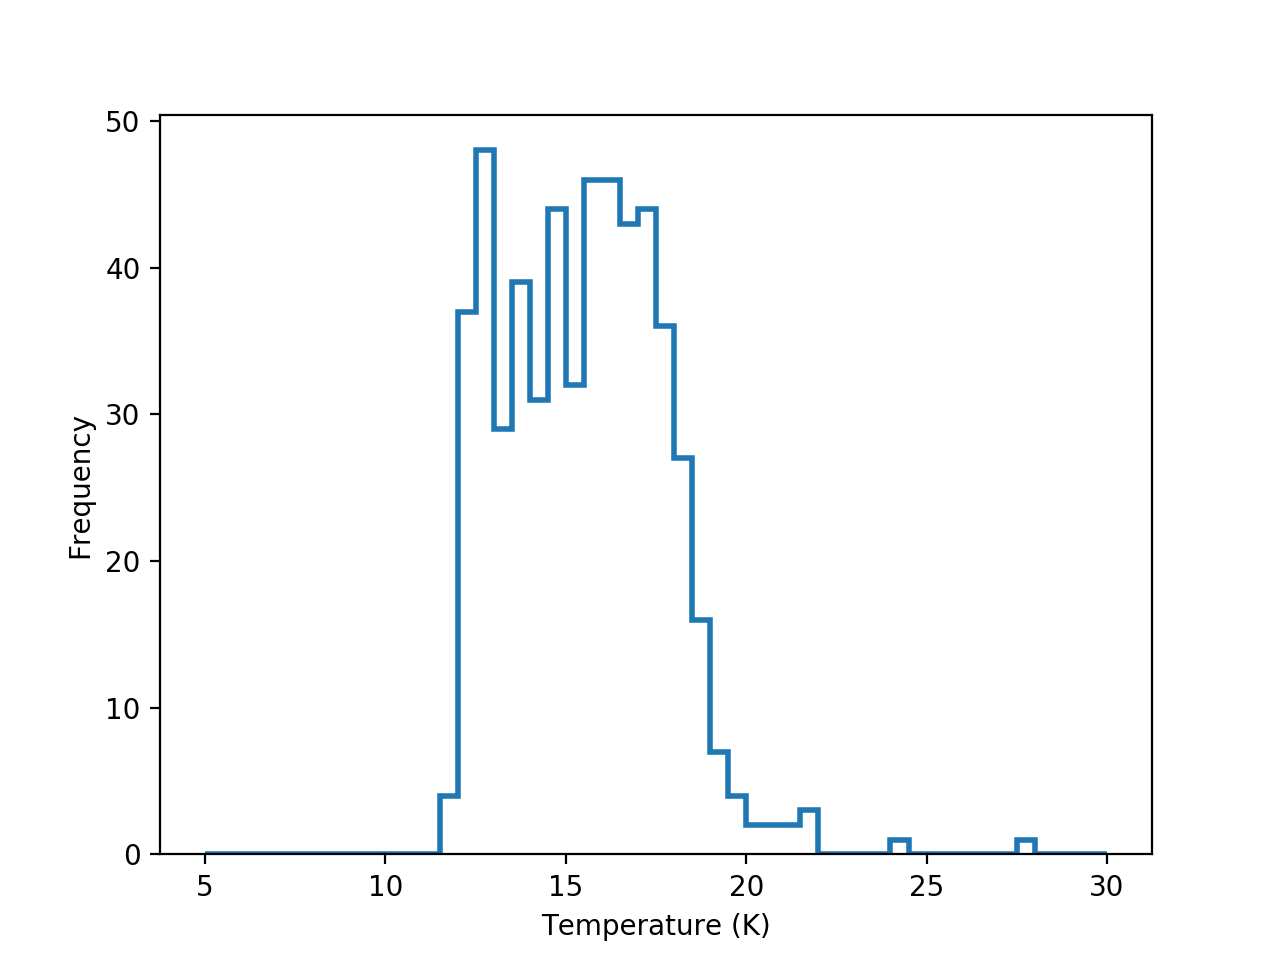

<IPython.core.display.Javascript object>


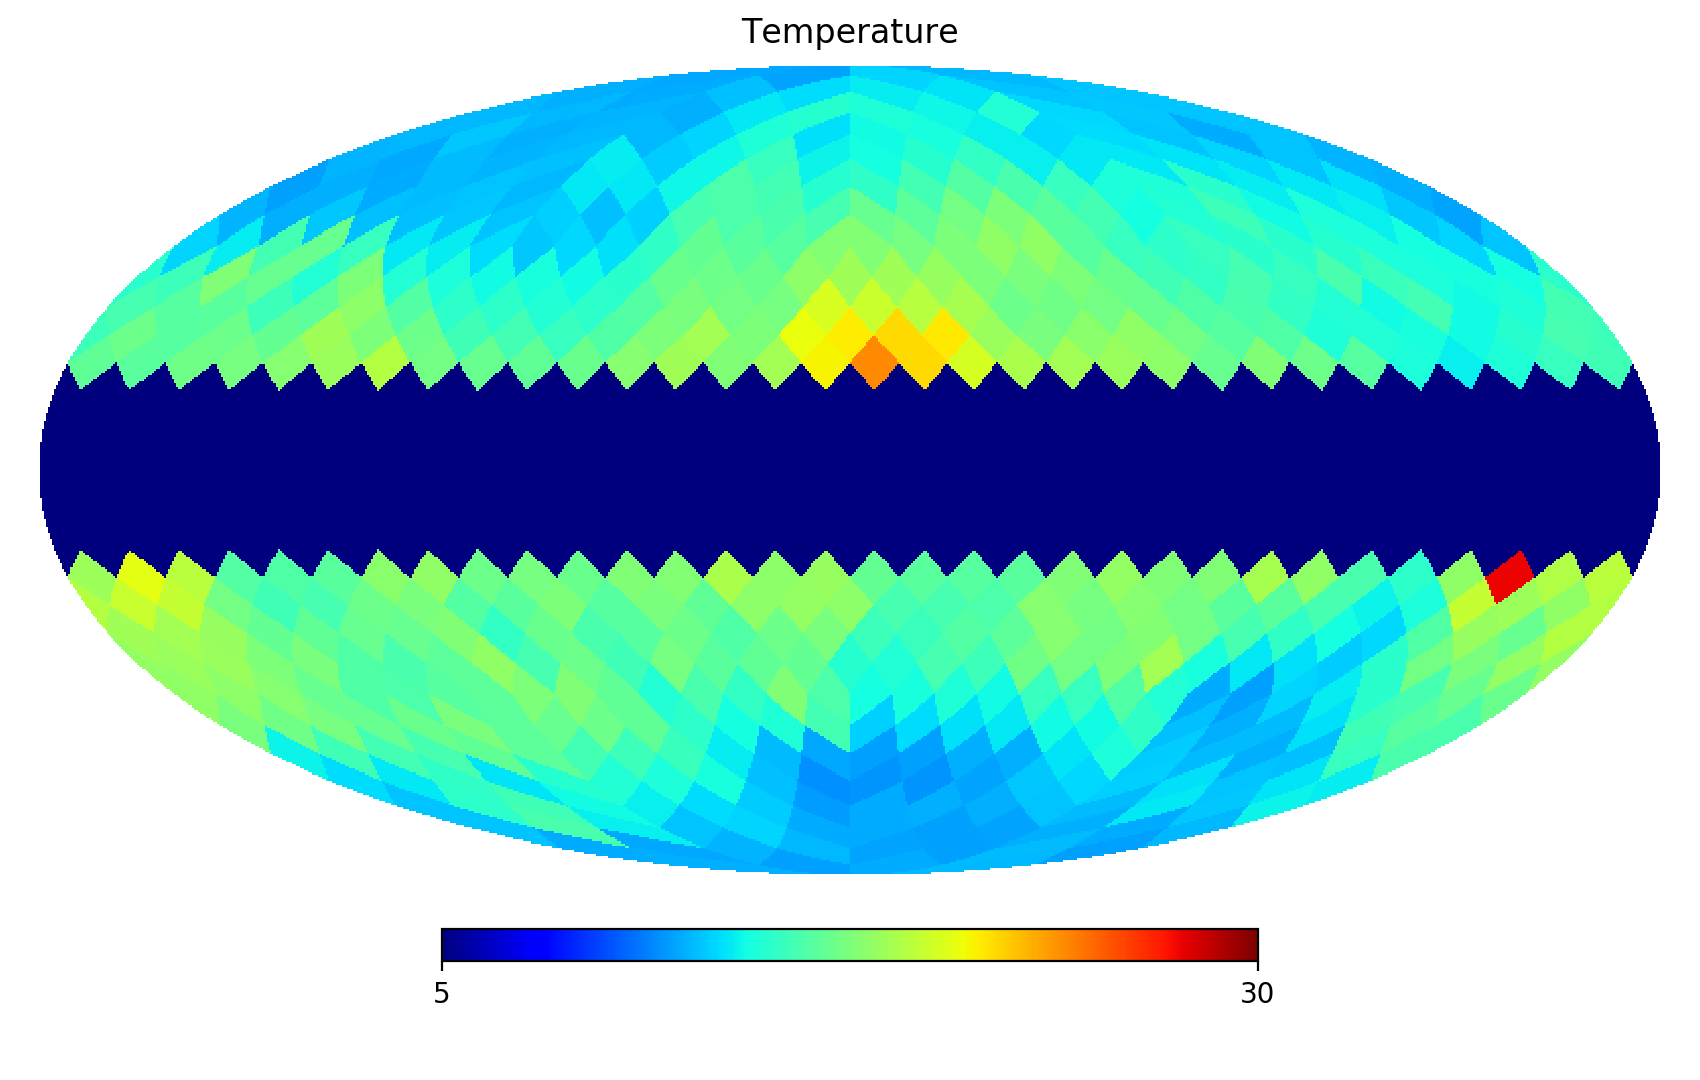

<IPython.core.display.Javascript object>


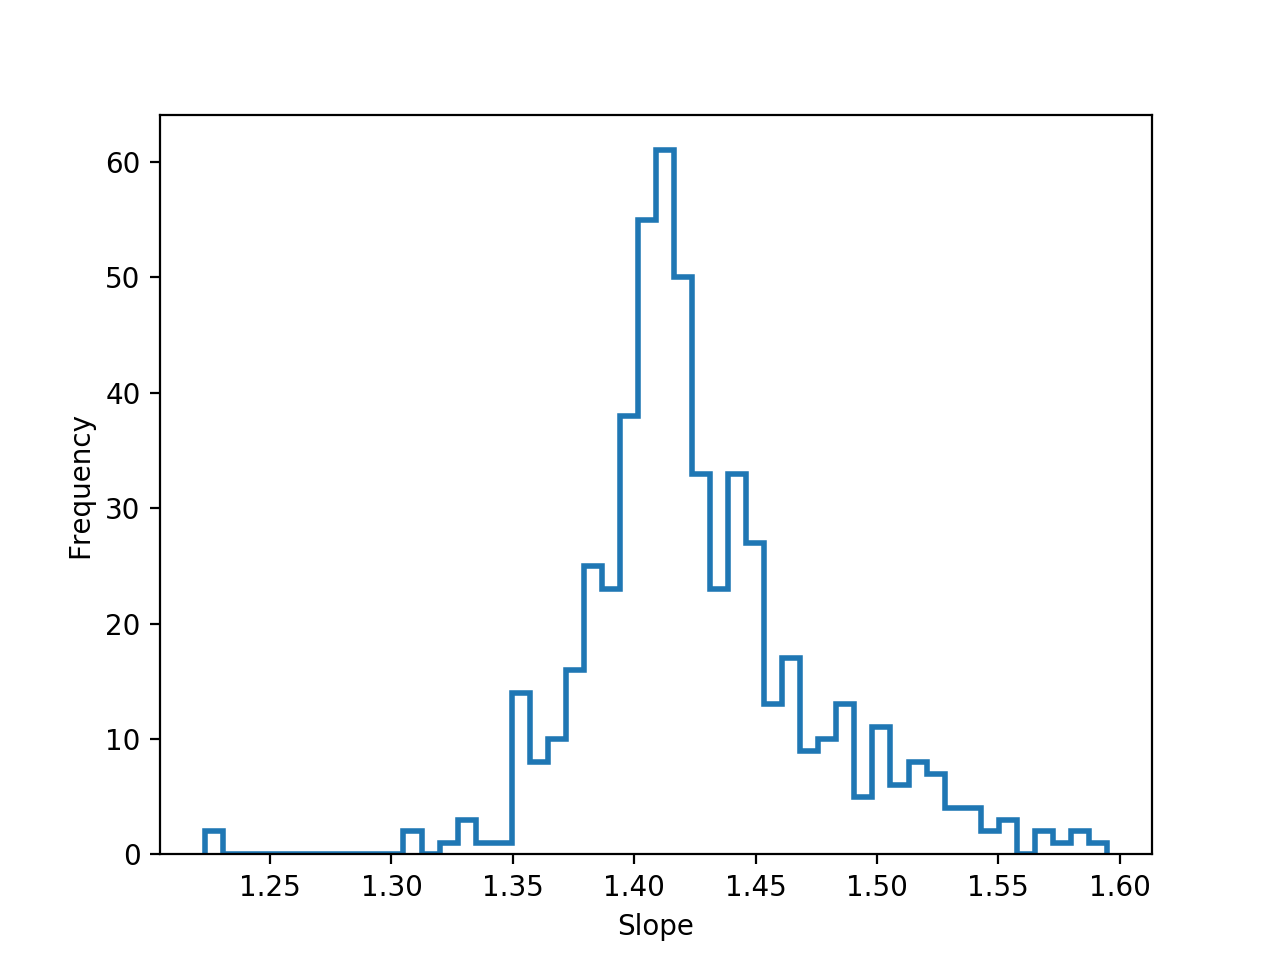

<IPython.core.display.Javascript object>


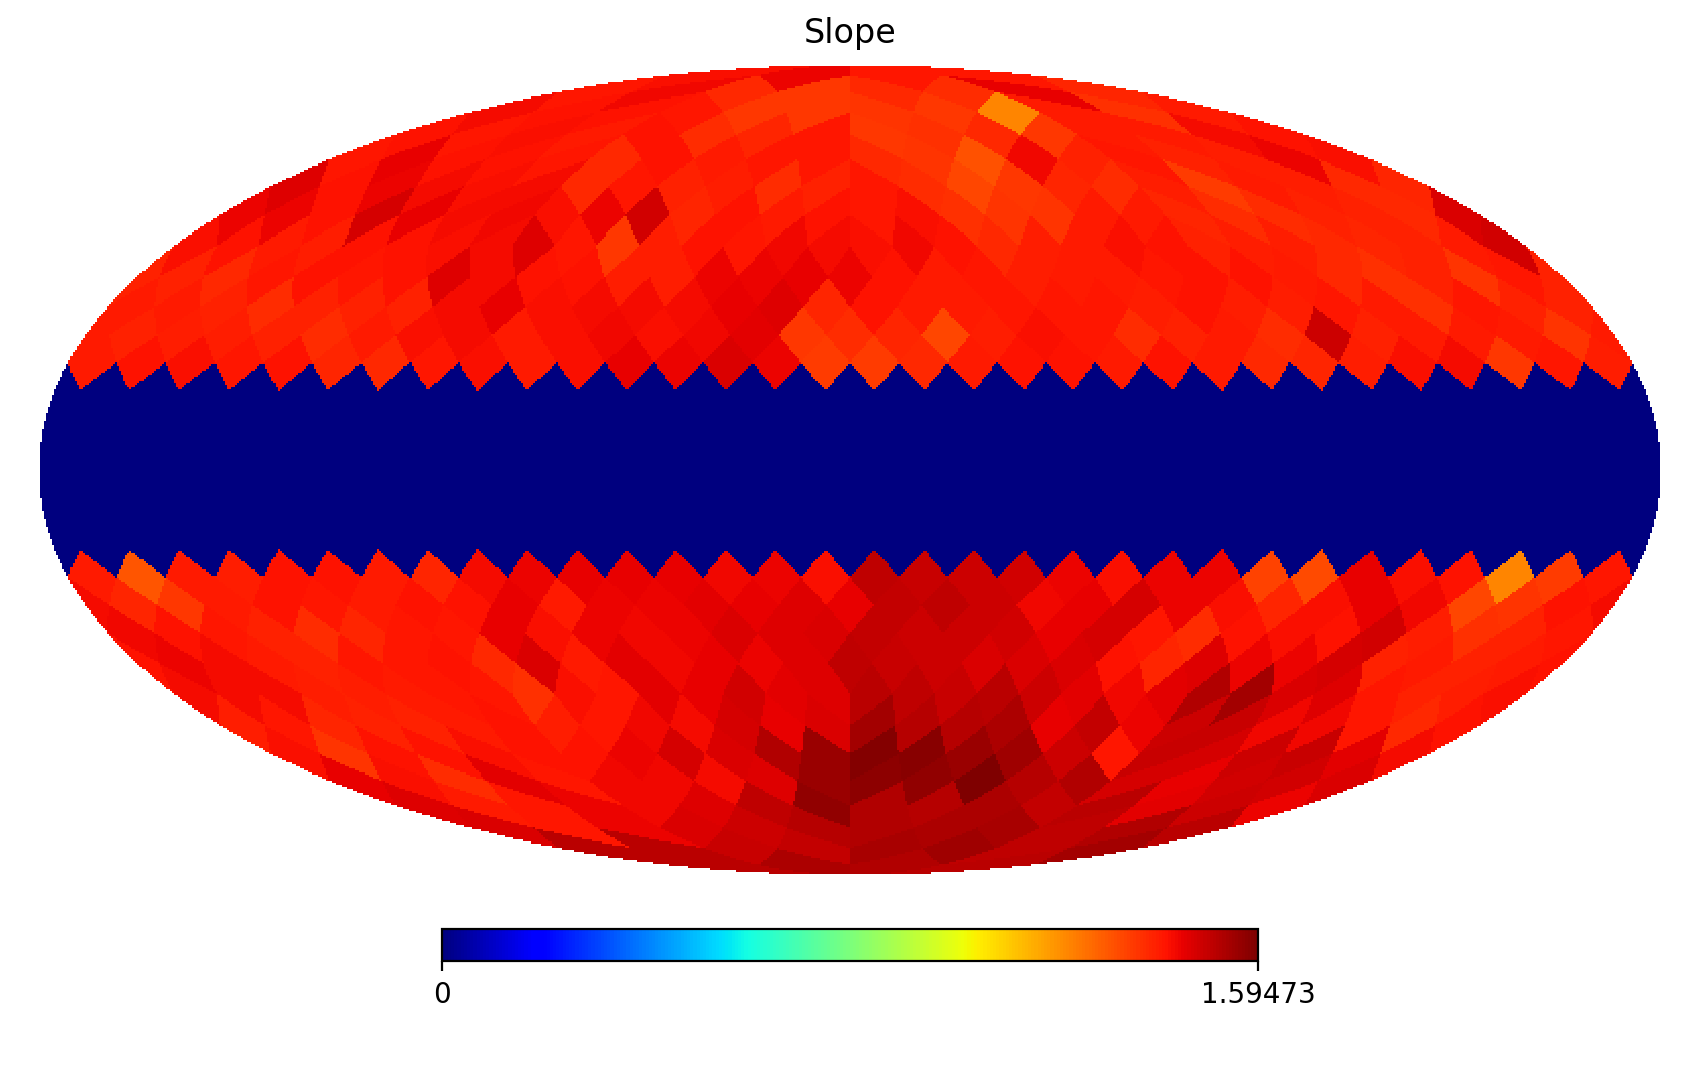

In [43]:
figure()
hist(A_fit[band_mask!=0]*1e5,bins=50,histtype="step",linewidth=2)
#semilogx()
xlabel("Amplitude")
ylabel("Frequency")
savefig(figpath + "./pdf/mbb_fit_amplitude.pdf",bbox_inches="tight")
h.mollview(A_fit*band_mask,title="Amplitude")
savefig(figpath + "./pdf/mbb_fit_amplitude_map.pdf",bbox_inches="tight")

print mean(T_fit)
figure()
hist(T_fit[band_mask!=0],bins=50,histtype="step",range=[5,30],linewidth=2)
xlabel("Temperature (K)")
ylabel("Frequency")
savefig(figpath + "./pdf/mbb_fit_temperature.pdf",bbox_inches="tight")
h.mollview(T_fit*band_mask,title="Temperature",min=5,max=30)
savefig(figpath + "./pdf/mbb_fit_temperature_map.pdf",bbox_inches="tight")


figure()
hist(slope_fit[band_mask!=0],bins=50,histtype="step",linewidth=2)
xlabel("Slope")
ylabel("Frequency")
savefig(figpath + "./pdf/mbb_fit_slope.pdf",bbox_inches="tight")
h.mollview(slope_fit*band_mask,title="Slope")
savefig(figpath + "./pdf/mbb_fit_slope_map.pdf",bbox_inches="tight")

In [ ]:
nu=np.array(freq).astype("float")
mlsoln=mlfit.ml_moment_fit(4)
numvec=6
moments_map=np.zeros((numvec,h.nside2npix(nside_moments)),float)
moments_cov=np.zeros((numvec,h.nside2npix(nside_moments)),float)
moments_noise=np.zeros((numvec,h.nside2npix(nside_moments)),float)
rec_hfi=np.zeros((6,h.nside2npix(nside_moments)),float)
for i in range(num_freq_pix):
    T=T_fit[i] ; slope=slope_fit[i]
    v=h.boundaries(nside_freq,i) ; v=np.swapaxes(v,0,1) 
    child_pixels=h.query_polygon(nside_moments,v)
    for pix in child_pixels:
        moments,cov,rec_inu=mlsoln.get_ml_moment_soln(nu,T,slope,2,hfi[:,pix],err_Inu=hfi_err[:,pix],inc_1der=True,n_is_der_order=True)
        moments_map[:,pix]=moments
        rec_hfi[:,pix]=rec_inu
        moments_cov[:,pix]=sqrt(diag(cov))
        moments,cov,rec_inu=mlsoln.get_ml_moment_soln(nu,T,slope,2,noise[:,pix],err_Inu=hfi_err[:,pix],inc_1der=True,n_is_der_order=True)
        moments_noise[:,pix]=moments

In [ ]:
ion()
for imom in range(numvec):
    rescale=1./median(moments_map[imom,:])
    figure()
    axvline(0,color="black")
    temp_data=moments_map[imom,:]*rescale
    temp_data2=moments_noise[imom,:]*rescale
    temp_moment=randn(num_moments_pix)*moments_cov[imom,:]*rescale
    mmin=median(temp_data[mask!=0]) - 3.*std(temp_data[mask!=0])
    mmax=median(temp_data[mask!=0]) + 3.*std(temp_data[mask!=0])

    hist(temp_data[mask!=0],bins=200,range=[mmin,mmax],histtype="step",linewidth=2,label="Data")
    hist(temp_data2[mask!=0],bins=200,range=[mmin,mmax],histtype="step",linewidth=2,color="black",alpha=0.6,label="Noise")
    hist(temp_moment[mask!=0],bins=200,range=[mmin,mmax],histtype="step",linewidth=2,color="magenta",alpha=0.6,label="Noise moment covariance")
    xlabel("Slope")
    ylabel("Frequency")
    legend(loc=0,title="Moment " + str(imom) + " (median =" + str('{:.2e}'.format(median(moments_map[imom,:]))) + ")")
    savefig(figpath + "./jpeg/histogram_moment_" +str(imom) + "_inc_1der.jpeg",bbox_inches="tight")

    h.mollview(temp_data*log10(11*mask-1),min=mmin,max=mmax,title="Moment " + str(imom) + " (median =" + str('{:.2e}'.format(median(moments_map[imom,:]))) + ")")
    savefig(figpath + "./jpeg/moment_" + str(imom) + "_inc_1der.jpeg")
    
    temp_data=(hfi[imom,:]-rec_hfi[imom,:])/hfi[imom,:]
    h.mollview(log10(abs(temp_data)),title=str(freq[imom]) + " GHz")
    text(0.,-1.35,r"$Log_{10}(\frac{|\Delta I_{\nu}|}{I_{\nu}})$")
    savefig(figpath + "./jpeg/data_sub_rec_data_" + str(imom) + "_inc_1der.jpeg")

<IPython.core.display.Javascript object>


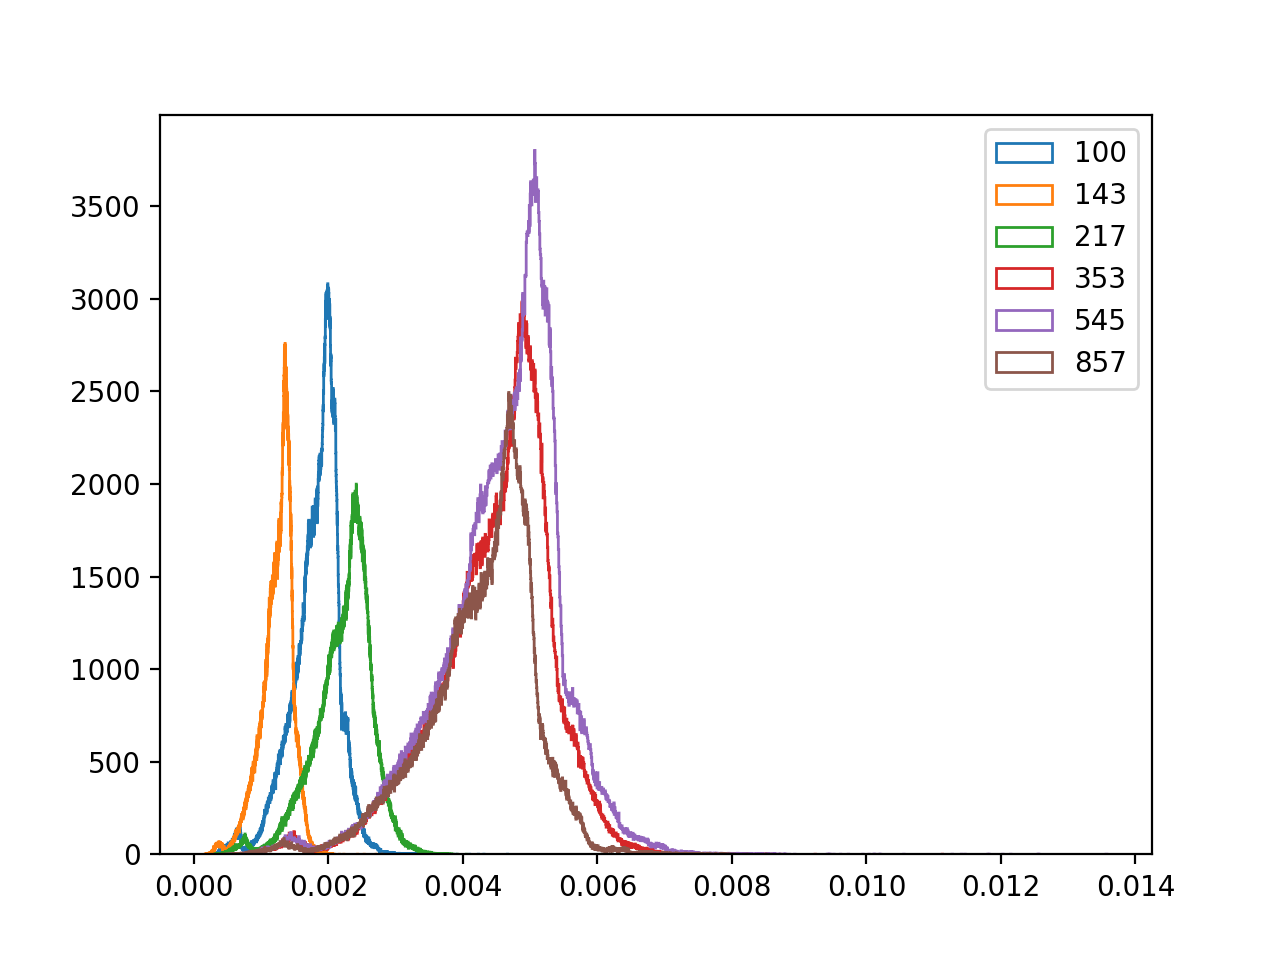

In [251]:
figure()
hist(hfi_err[0,:],bins=2000,histtype="step",label="100")
hist(hfi_err[1,:],bins=2000,histtype="step",label="143")
hist(hfi_err[2,:],bins=2000,histtype="step",label="217")
hist(hfi_err[3,:],bins=2000,histtype="step",label="353")
hist(hfi_err[4,:],bins=2000,histtype="step",label="545")
hist(hfi_err[5,:],bins=2000,histtype="step",label="857")
legend(loc=0)
#semilogx()

<IPython.core.display.Javascript object>


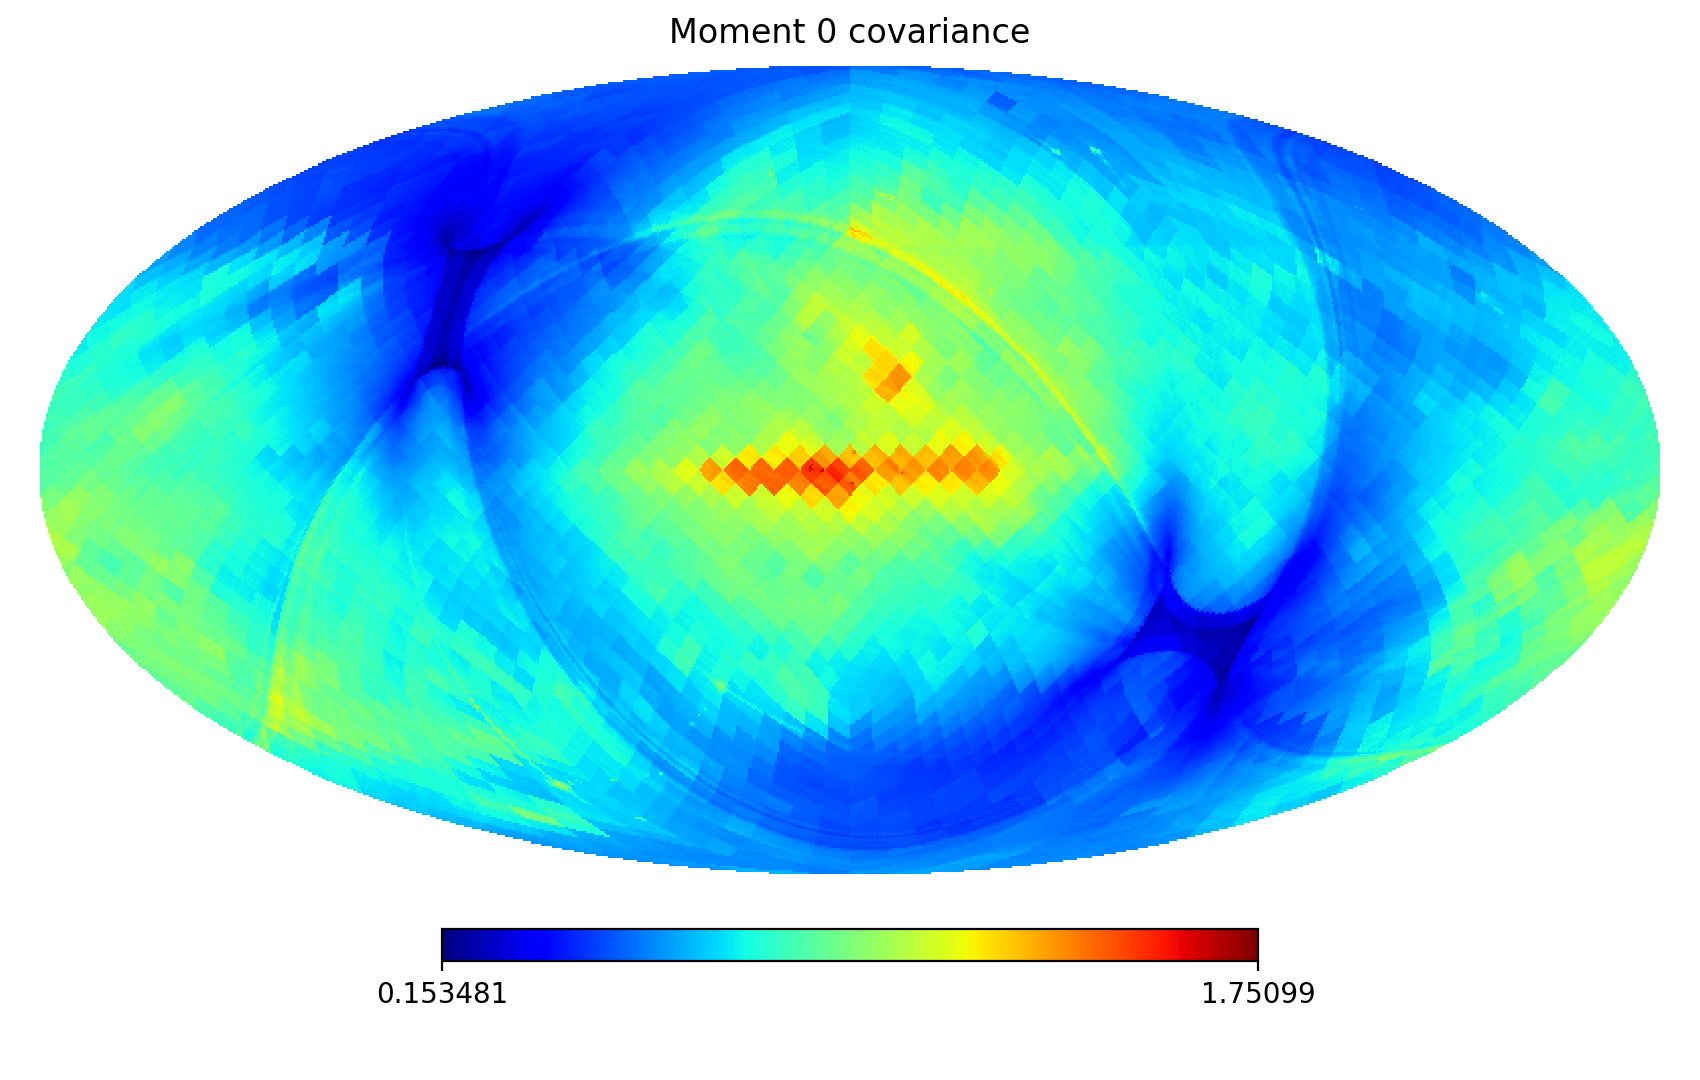

<IPython.core.display.Javascript object>


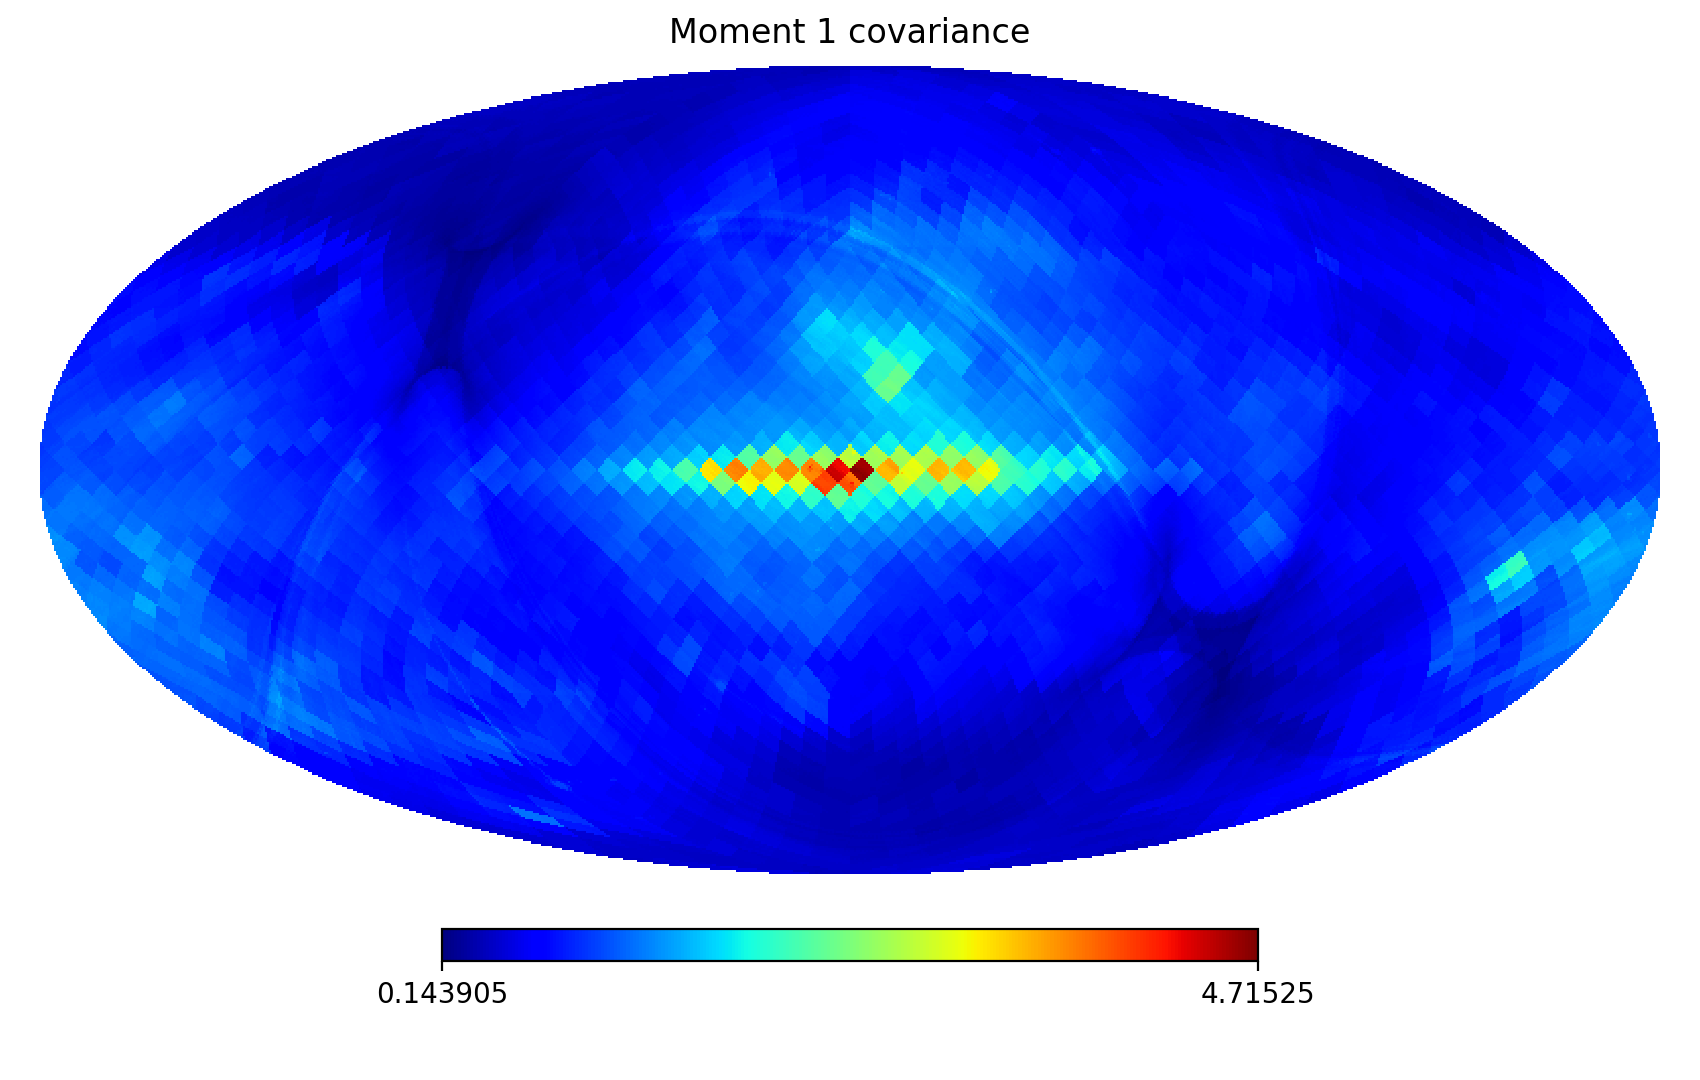

<IPython.core.display.Javascript object>


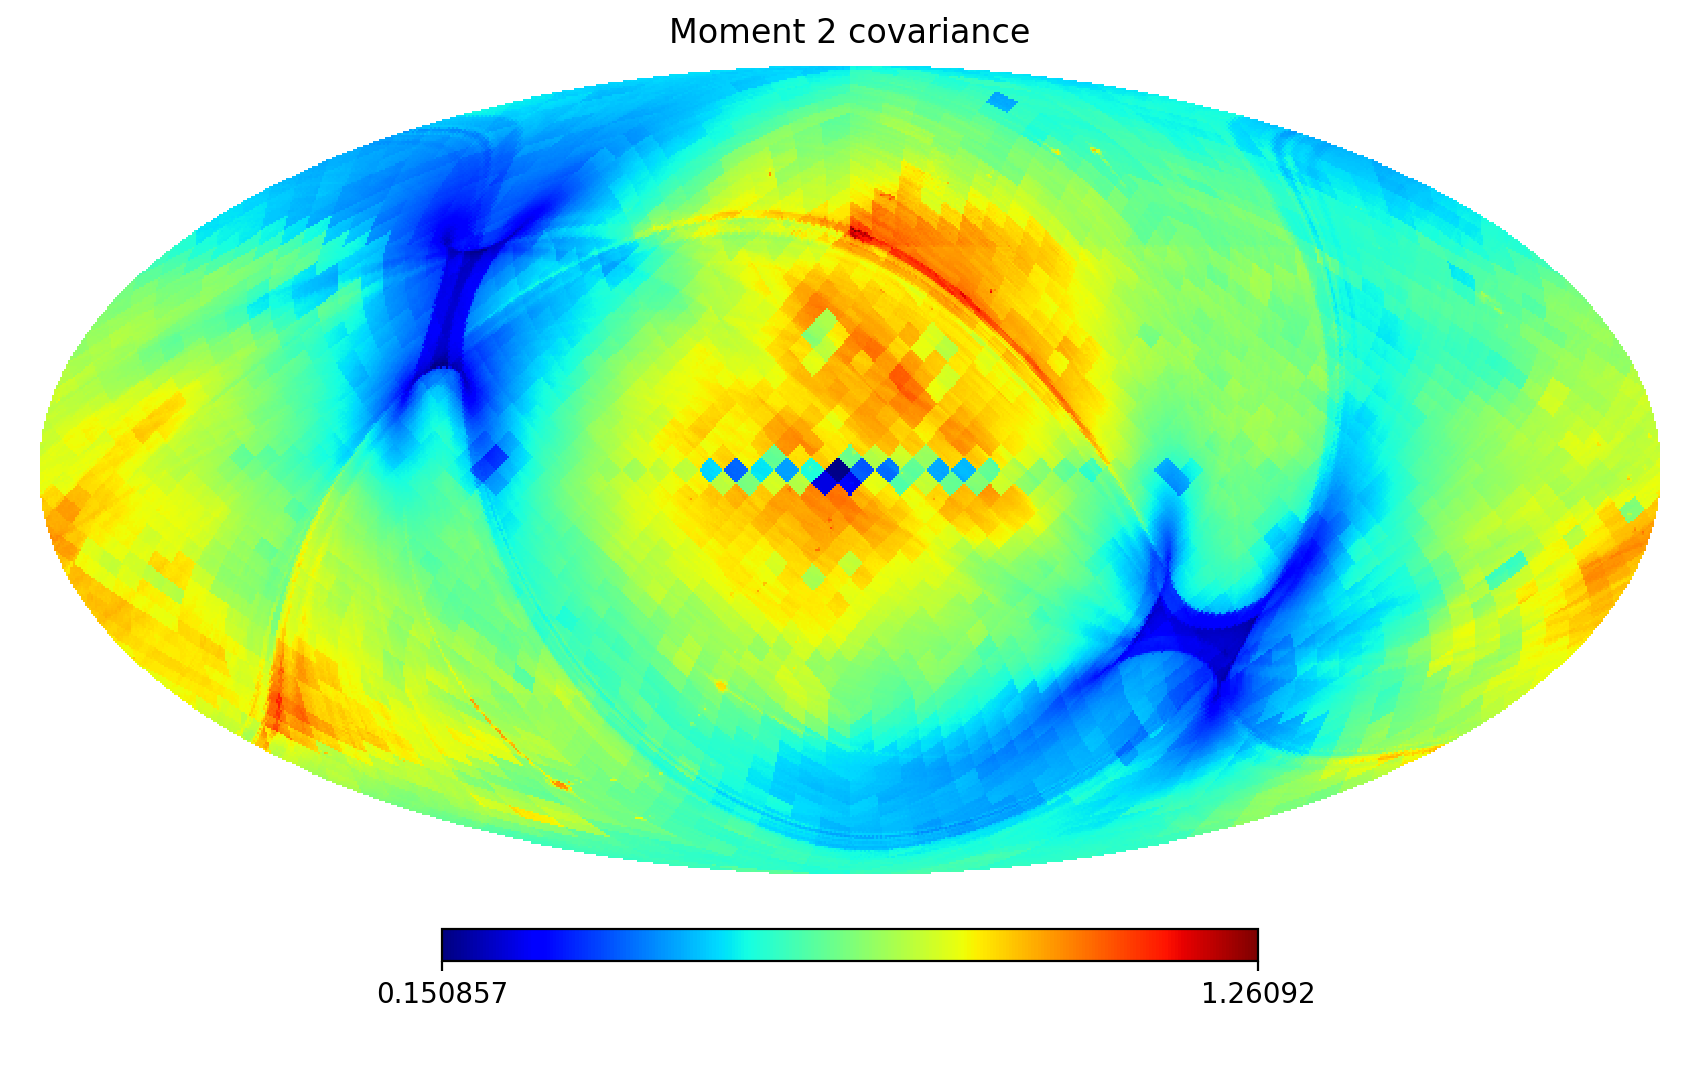

<IPython.core.display.Javascript object>


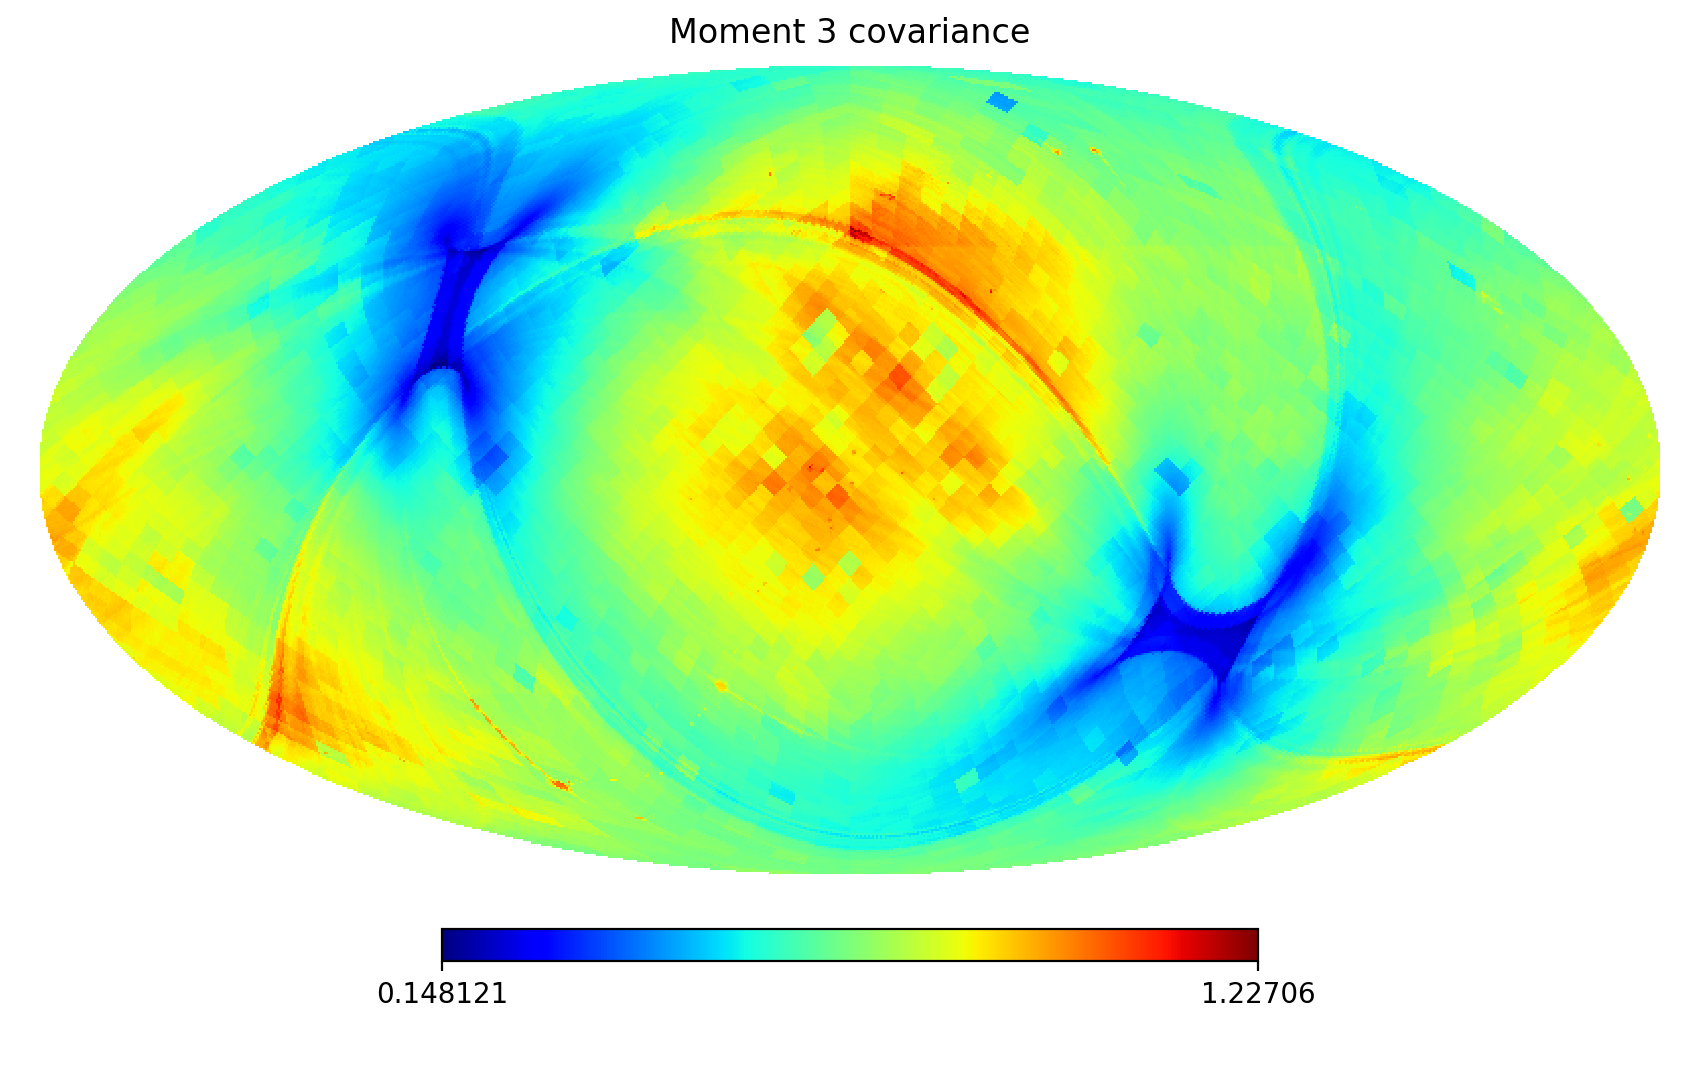

<IPython.core.display.Javascript object>


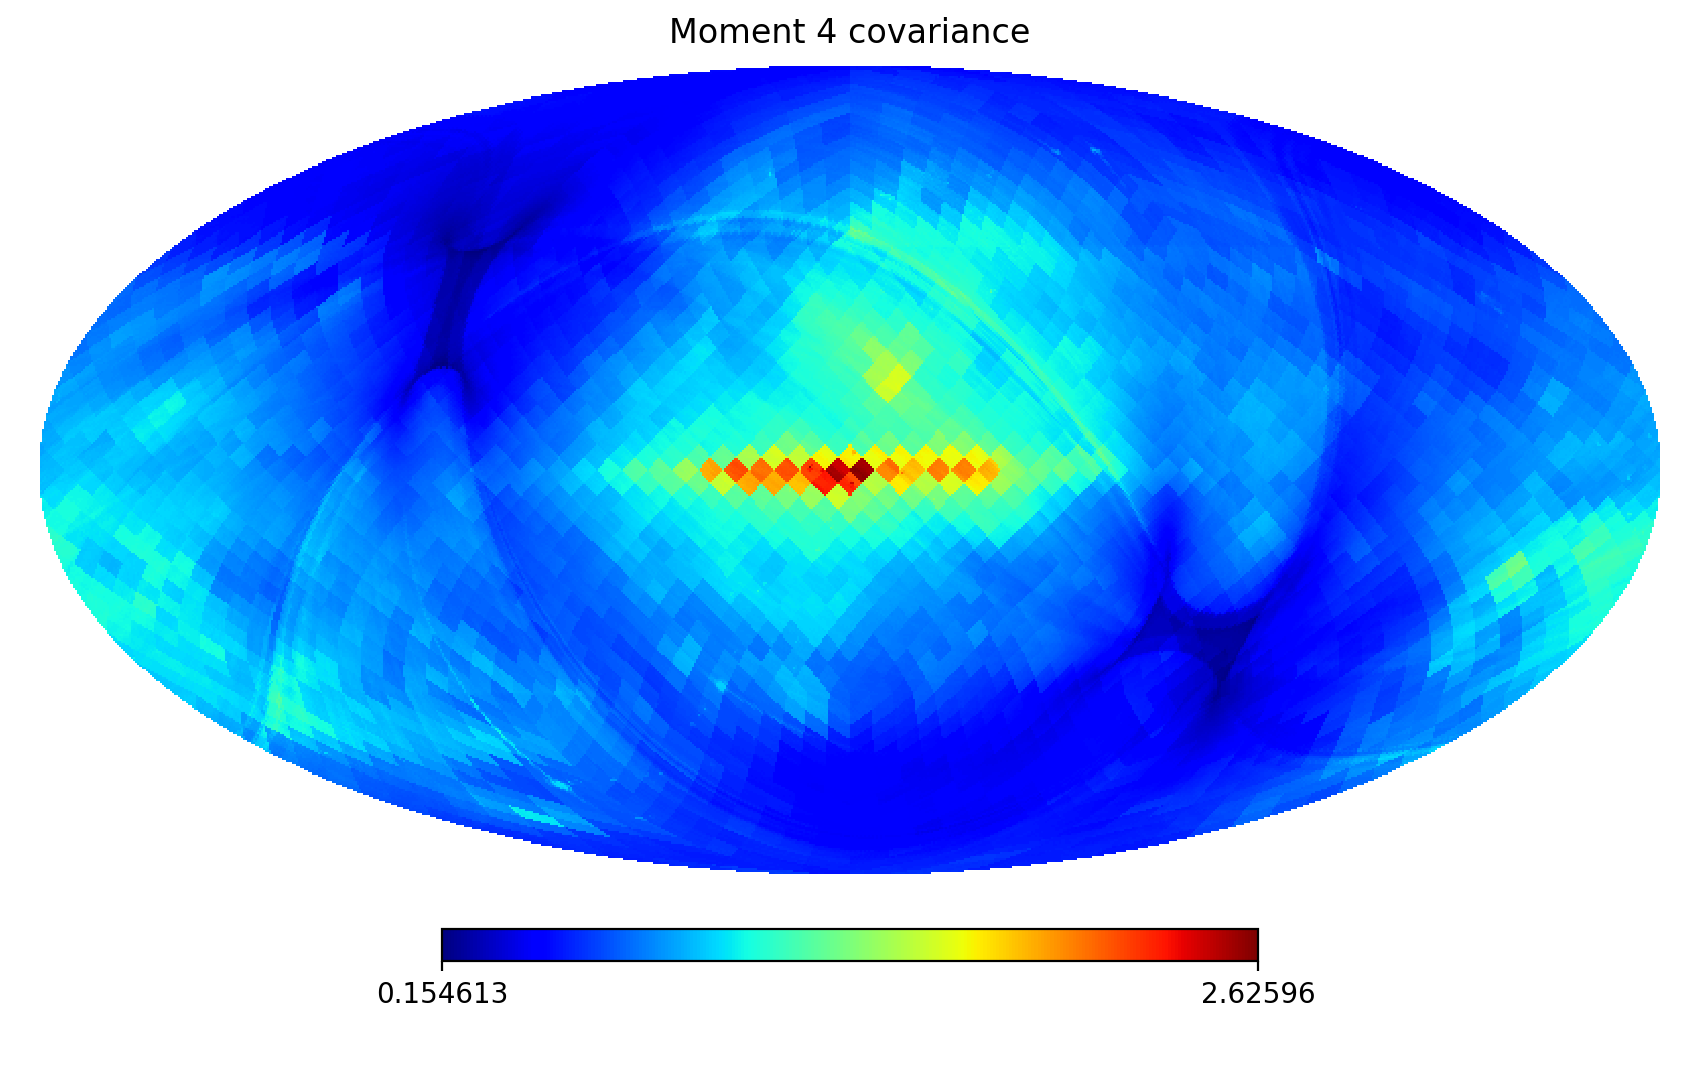

<IPython.core.display.Javascript object>


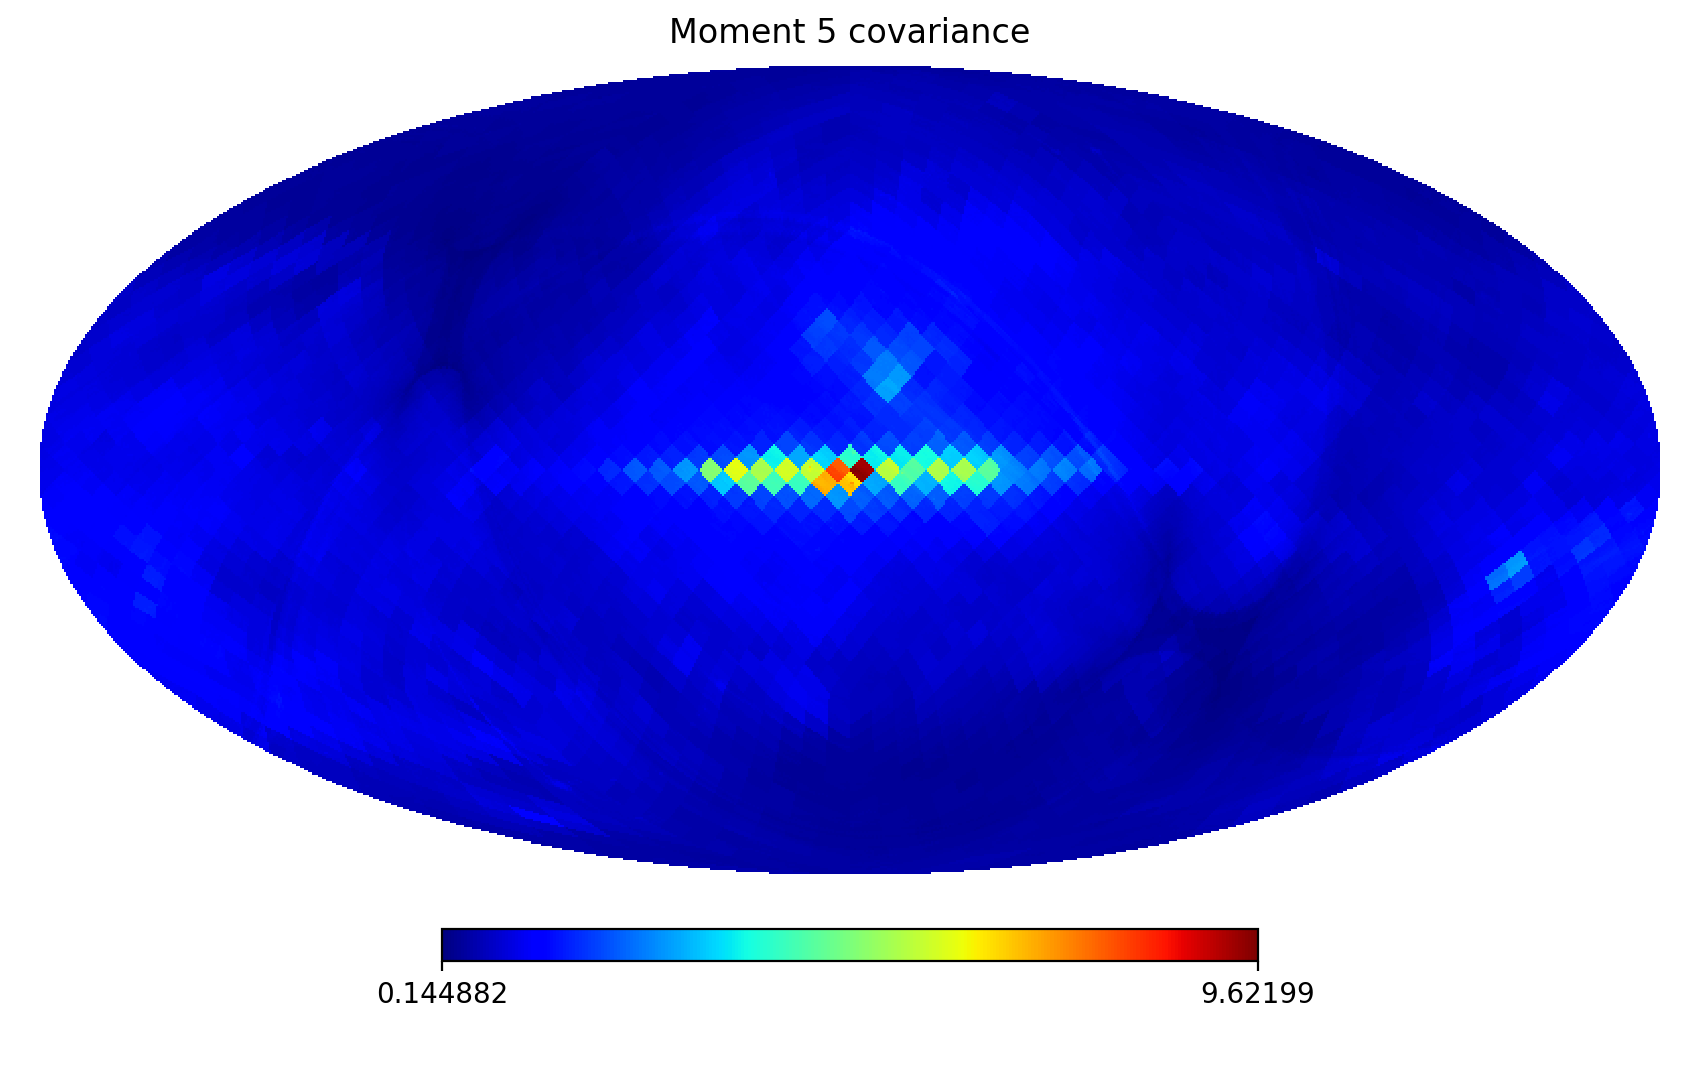

In [146]:
ioff()
for imom in range(numvec):
    rescale=abs(1./median(moments_map[imom,:]))
    h.mollview((moments_cov[imom,:]*rescale),title="Moment " + str(imom) + " covariance")
    savefig(figpath + "./jpeg/covariance_moment_"+str(imom)+"_inc_1der.jpeg")

In [149]:
workdir=os.getcwd()
os.chdir(figpath)
cmd="convert -quality 99 -density 150 -delay 120 -loop 0 ./jpeg/moment_*_inc_1der.jpeg Planck_hfi_moment_inc_1der.gif"
print cmd
os.system(cmd)
cmd="convert -quality 99 -density 150 -delay 120 -loop 0 ./jpeg/covariance_moment_*_inc_1der.jpeg Planck_hfi_moment_covariance_inc_1der.gif"
print cmd
os.system(cmd)
cmd="convert -quality 99 -density 150 -delay 120 -loop 0 ./jpeg/histogram_moment_*_inc_1der.jpeg Planck_hfi_moment_histogram_inc_1der.gif"
print cmd
os.system(cmd)
cmd="convert -quality 99 -density 150 -delay 180 -loop 0 ./jpeg/data_sub_rec_data_*_inc_1der.jpeg data_sub_rec_data_inc_1der.gif"
print cmd
os.system(cmd)
os.chdir(workdir)

convert -quality 99 -density 150 -delay 120 -loop 0 ./jpeg/moment_*_inc_1der.jpeg Planck_hfi_moment_inc_1der.gif
convert -quality 99 -density 150 -delay 120 -loop 0 ./jpeg/covariance_moment_*_inc_1der.jpeg Planck_hfi_moment_covariance_inc_1der.gif
convert -quality 99 -density 150 -delay 120 -loop 0 ./jpeg/histogram_moment_*_inc_1der.jpeg Planck_hfi_moment_histogram_inc_1der.gif
convert -quality 99 -density 150 -delay 180 -loop 0 ./jpeg/data_sub_rec_data_*_inc_1der.jpeg data_sub_rec_data_inc_1der.gif


<IPython.core.display.Javascript object>


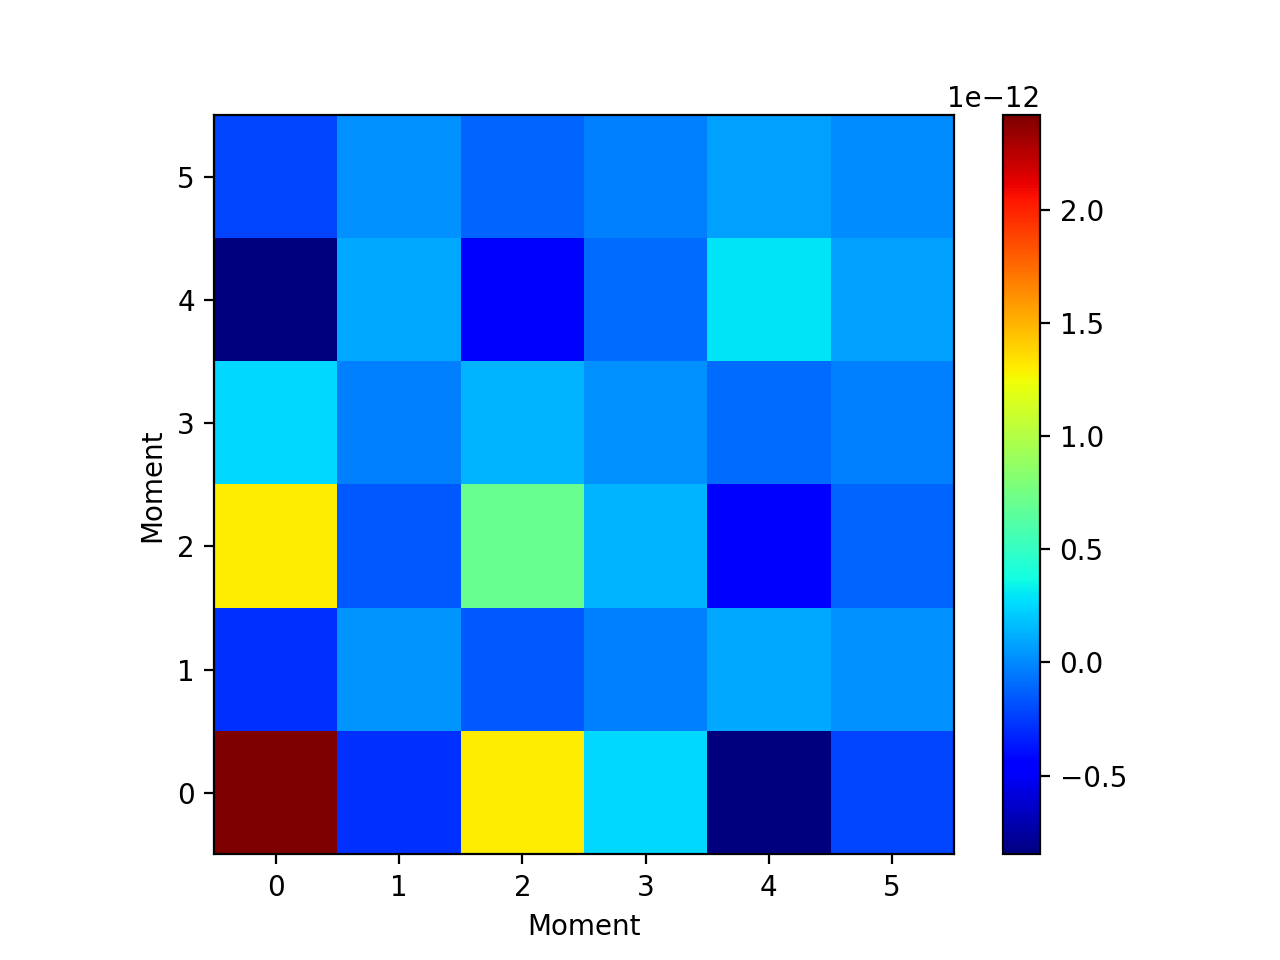

In [148]:
figure()
imshow(cov,origin="lower")
colorbar()
xlabel("Moment")
ylabel("Moment")
savefig(figpath + "moment_covariance_inc_1der.pdf",bbox_inches="tight")

In [ ]:
ioff()
for i,nu in enumerate(freq):
    h.mollview((hfi[i,:]+cmb_freq[i,:])*log10(11*mask-1),max=max(hfi[i,:][mask!=0])*0.2,title=str(nu) + " GHz")
    savefig(figpath + "./jpeg/hfi_wi_cmb_" +str(nu) + ".jpeg")
    h.mollview(hfi[i,:]*log10(11*mask-1),max=max(hfi[i,:][mask!=0])*0.2,title=str(nu) + " GHz")
    savefig(figpath + "./jpeg/hfi_wo_cmb_" +str(nu) + ".jpeg")

workdir=os.getcwd()
os.chdir(figpath)
for nu in freq:
    cmd="convert -quality 99 -density 50 -delay 120 -loop 0 ./jpeg/hfi_wi_cmb_" + str(nu) + ".jpeg ./jpeg/hfi_wo_cmb_" + str(nu) + ".jpeg animate_hfi_cmb_" + str(nu)+".gif"
    print cmd
    os.system(cmd)
os.chdir(workdir)